In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Monoton&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Monoton; color:#ff1155; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import os,torch
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torchvision import transforms,utils
from PIL import Image
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
train_csv='train.csv'; test_csv='test.csv'
img_path='AFAD-Lite'

In [4]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break

In [5]:
dhtml('Data')

In [6]:
!git clone https://github.com/afad-dataset/tarball-lite.git

Cloning into 'tarball-lite'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.
Checking out files: 100% (30/30), done.


In [7]:
!cat tarball-lite/AFAD-Lite.tar.xz*>tarball-lite/AFAD-Lite.tar.xz

In [8]:
!tar xf tarball-lite/AFAD-Lite.tar.xz

In [9]:
files=[os.path.relpath(os.path.join(dirpath,fn),img_path) \
for (dirpath,dirnames,filenames) in os.walk(img_path) \
for fn in filenames if fn.endswith('.jpg')]
d={'age':[],'gender':[],
   'file':[],'path':[]}
for f in files:
    age,gender,fn=f.split('/')
    if gender=='111': gender='male'
    else: gender='female'        
    d['age'].append(age)
    d['gender'].append(gender)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
df['age']=df['age'].values.astype(int)-18
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test.to_csv(test_csv)
num_classes=np.unique(df['age'].values).shape[0]
print([num_classes,len(files)]); df.head()

[22, 59344]


,age,gender,file,path
0,14,female,446299-0.jpg,32/112/446299-0.jpg
1,14,female,436087-0.jpg,32/112/436087-0.jpg
2,14,female,123817-0.jpg,32/112/123817-0.jpg
3,14,female,8444-1.jpg,32/112/8444-1.jpg
4,14,female,310410-1.jpg,32/112/310410-1.jpg


In [10]:
class AFADAgeData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['age'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [11]:
batch_size=256; num_workers=4
grayscale=False; img_size=120
trans=transforms\
.Compose([transforms.Resize((128,128)),
          transforms.RandomCrop((img_size,img_size)),
          transforms.ToTensor()])
trans2=transforms\
.Compose([transforms.Resize((128,128)),
          transforms.CenterCrop((img_size,img_size)),
          transforms.ToTensor()])
train=AFADAgeData(csv_path=train_csv,
                  img_dir=img_path,
                  transform=trans)
test=AFADAgeData(csv_path=test_csv,
                 img_dir=img_path,
                 transform=trans2)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers)}

Image dimensions: torch.Size([256, 3, 120, 120])
Label dimensions: torch.Size([256])


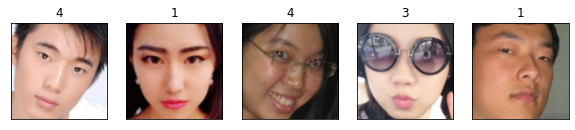

In [12]:
%display_examples test

In [13]:
dhtml('Ordinal Regression CNN')

In [14]:
def conv31(in_planes,out_planes,stride=1):
    return tnn.Conv2d(in_planes,out_planes,
                      kernel_size=3,stride=stride,
                      padding=1,bias=False)
def cost_fit(targets,predictions):
    return torch.mean((targets.float()-predictions)**2)
def mae_mse(model,data_loader):
    mae,mse,num_examples=\
    torch.tensor([0.]),torch.tensor([0.]),0
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.float().to(dev)
        logits,probs,predictions=model(features)
        assert len(targets.size())==1
        assert len(predictions.size())==1
        predicted_labels=torch.round(predictions).float()
        num_examples+=targets.size(0)
        mae+=torch.abs(predicted_labels-targets).sum()
        mse+=torch.sum((predicted_labels-targets)**2)
    return mae/num_examples,mse/num_examples

In [15]:
class BasicBlock(tnn.Module):
    expansion=1
    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=conv31(inplanes,planes,stride)
        self.bn1=tnn.BatchNorm2d(planes)
        self.relu=tnn.ReLU(inplace=True)
        self.conv2=conv31(planes,planes)
        self.bn2=tnn.BatchNorm2d(planes)
        self.downsample=downsample
        self.stride=stride
    def forward(self,x):
        residual=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        if self.downsample is not None:
            residual=self.downsample(x)
        out+=residual
        out=self.relu(out)
        return out

In [16]:
class ResNN(tnn.Module):
    def __init__(self, block,layers,num_classes,grayscale):
        self.num_classes=num_classes
        self.inplanes=64
        base_num=64
        if grayscale: in_dim=1
        else: in_dim=3
        super(ResNN,self).__init__()
        self.conv1=tnn\
        .Conv2d(in_dim,base_num,kernel_size=7,
                stride=2,padding=3,bias=False)
        self.bn1=tnn.BatchNorm2d(base_num)
        self.relu=tnn.ReLU(inplace=True)
        self.maxpool=tnn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,base_num,layers[0])
        self.layer2=self._make_layer(block,2*base_num,layers[1],stride=2)
        self.layer3=self._make_layer(block,4*base_num,layers[2],stride=2)
        self.layer4=self._make_layer(block,8*base_num,layers[3],stride=2)
        self.avgpool=tnn.AvgPool2d(7,stride=1,padding=2)
        self.fc=tnn.Linear(2048*block.expansion,num_classes)
        self.a=tnn.Parameter(torch.zeros(
            self.num_classes).float().normal_(0.,.1).view(-1,1))
        for m in self.modules():
            if isinstance(m,tnn.Conv2d):
                n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
                m.weight.data.normal_(0,(2./n)**.5)
            elif isinstance(m,tnn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self,block,planes,blocks,stride=1):
        downsample=None
        if stride!=1 or self.inplanes!=planes*block.expansion:
            downsample=tnn.Sequential(
                tnn.Conv2d(self.inplanes,planes*block.expansion,
                           kernel_size=1,stride=stride,bias=False),
                tnn.BatchNorm2d(planes*block.expansion),)

        layers=[]
        layers.append(block(self.inplanes,planes,stride,downsample))
        self.inplanes=planes*block.expansion
        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes))
        return tnn.Sequential(*layers)
    def forward(self, x):
        x=self.conv1(x); x=self.bn1(x)
        x=self.relu(x); x=self.maxpool(x)
        x=self.layer1(x); x=self.layer2(x)
        x=self.layer3(x); x=self.layer4(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),-1)
        logits=self.fc(x)
        probs=torch.softmax(logits,dim=1)
        predictions=((self.num_classes-1)*torch\
                     .sigmoid(probs.mm(self.a).view(-1)))
        return logits,probs,predictions
def ResNN34(num_classes,grayscale):
    return ResNN(block=BasicBlock,
                 layers=[3,4,6,3],
                 num_classes=num_classes,
                 grayscale=grayscale)

In [17]:
dhtml('Training')

In [18]:
random_seed=12; learning_rate=.0005
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
model=ResNN34(num_classes,grayscale)
model.to(dev)
optimizer=torch.optim\
.Adam(model.parameters(),lr=learning_rate)

In [19]:
epochs=50
for epoch in range(epochs):
    model.train()
    for batch_ids,(features,targets) \
    in enumerate(dataloaders['train']):
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs,predictions=model(features)
        assert len(targets.size())==1
        assert len(predictions.size())==1
        cost=cost_fit(targets,predictions)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if not batch_ids%50:
            st='Epoch: %03d/%03d | Batch: %04d/%04d | Cost: %.4f'
            print(st%(epoch+1,epochs,batch_ids,
                     len(dataloaders['train']),cost))

Epoch: 001/050 | Batch: 0000/0186 | Cost: 43.6718
Epoch: 001/050 | Batch: 0050/0186 | Cost: 35.5432
Epoch: 001/050 | Batch: 0100/0186 | Cost: 41.2877
Epoch: 001/050 | Batch: 0150/0186 | Cost: 37.3640
Epoch: 002/050 | Batch: 0000/0186 | Cost: 40.2177
Epoch: 002/050 | Batch: 0050/0186 | Cost: 36.4511
Epoch: 002/050 | Batch: 0100/0186 | Cost: 36.9714
Epoch: 002/050 | Batch: 0150/0186 | Cost: 37.6121
Epoch: 003/050 | Batch: 0000/0186 | Cost: 34.3402
Epoch: 003/050 | Batch: 0050/0186 | Cost: 36.2467
Epoch: 003/050 | Batch: 0100/0186 | Cost: 36.2629
Epoch: 003/050 | Batch: 0150/0186 | Cost: 32.1105
Epoch: 004/050 | Batch: 0000/0186 | Cost: 39.2849
Epoch: 004/050 | Batch: 0050/0186 | Cost: 39.3572
Epoch: 004/050 | Batch: 0100/0186 | Cost: 32.0630
Epoch: 004/050 | Batch: 0150/0186 | Cost: 42.8950
Epoch: 005/050 | Batch: 0000/0186 | Cost: 31.8711
Epoch: 005/050 | Batch: 0050/0186 | Cost: 35.3363
Epoch: 005/050 | Batch: 0100/0186 | Cost: 33.2725
Epoch: 005/050 | Batch: 0150/0186 | Cost: 33.4530


In [20]:
dhtml('Evaluation')

In [21]:
model.eval()
with torch.set_grad_enabled(False):
    train_mae,train_mse=\
    mae_mse(model,dataloaders['train'])
    test_mae,test_mse=\
    mae_mse(model,dataloaders['test'])
    st='MAE/RMSE => Train: %.2f/%.2f | Test: %.2f/%.2f'
    print(st%(train_mae,torch.sqrt(train_mse),
              test_mae,torch.sqrt(test_mse)))

MAE/RMSE => Train: 2.33/3.00 | Test: 3.48/4.62
